## Wu-Yang Method for KS Inversion
Please check the original paper of the PDE-Constrained Optimization method: \
[Jensen Wasserman, Int J Quantum Chem. 2018;118:e25425](https://onlinelibrary.wiley.com/doi/full/10.1002/qua.25425);\
[Kanungo, Zimmerman, Gavini, Nat Commun 10, 4497 (2019)](https://doi.org/10.1038)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter(wfn, pbs="aug-cc-pvqz")

---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{rest}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_max_iter=200, guide_potential_components=["fermi_amaldi"], gtol=1e-6)

Optimization Successful within 146 iterations! |grad|=4.53e-05.


---
### Visualization
#### Visualization of the potentials. 

#### Since this is a 1-D system, let's first plot it alone x axis.

Building grids

In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])
grids.shape

(3, 101)

Or the grids can be generate alternatively by np.meshgrid and flatten.

In [5]:
grids_temp, _ = ine.generate_grids(x=x, y=[0], z=[0])
np.allclose(grids_temp, grids)

True

Get Hartree and Fermi-Amaldi potentials

In [6]:
vH, vFA = ine.on_grid_esp(grid=grids)[1:3]
assert np.allclose(vFA, vH * (1-1/(ine.nalpha+ine.nbeta)))

Get exchange-correlation potentials.
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [7]:
vrest = ine.on_grid_ao(ine.v_pbs, grid=grids, basis=ine.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.

In [8]:
vxc = vFA + vrest - vH

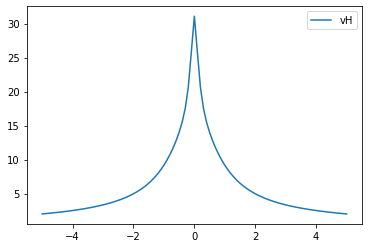

In [9]:
plt.plot(x, vH, label="vH")
plt.legend()

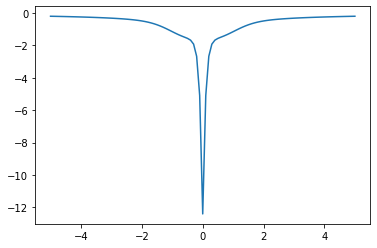

In [10]:
plt.plot(x, vxc, label="vxc")

Let's try unrestricted.

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "uhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter(wfn, pbs="aug-cc-pvqz")

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_max_iter=200, guide_potential_components=["fermi_amaldi"], gtol=1e-6)

Optimization Successful within 106 iterations! |grad|=2.21e-05.


In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])
grids.shape

vH, vFA = ine.on_grid_esp(grid=grids)[1:3]
assert np.allclose(vFA, vH * (1-1/(ine.nalpha+ine.nbeta)))

In [11]:
vrest_a = ine.on_grid_ao(ine.v_pbs[:ine.npbs], grid=grids, basis=ine.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.
vxc_a = vFA + vrest_a - vH

In [12]:
vrest_b = ine.on_grid_ao(ine.v_pbs[ine.npbs:], grid=grids, basis=ine.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.
vxc_b = vFA + vrest_b - vH

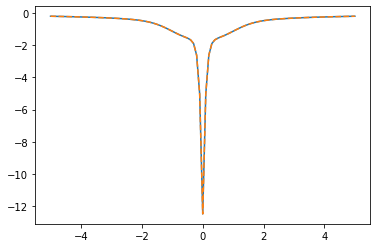

In [13]:
plt.plot(x, vxc_a, label="vxc")
plt.plot(x, vxc_b, label="vxc", ls="--")